# GISTDA Wildfire Machine Learning Training

## Import and Read SHAPE File

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import dask.dataframe as dd
import rasterio
import tensorflow as tf
import dask
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from dask import delayed, compute
from concurrent.futures import ThreadPoolExecutor
from rasterio.windows import Window

#pd.set_option("display.max_columns", None)  # To show all columns in a pandas DataFrame

# Define the folder containing the raster files
raster_train_file_path = r'Raster_Train'

# Parameters for chunk size
CHUNK_SIZE = 1024

@delayed
def read_raster_in_chunks(raster_path, file, root):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        num_bands = src.count
        band_names = [f'B{str(i).zfill(2)}' for i in range(1, num_bands + 1)]
        chunk_dfs = []
        
        # Loop over the raster in chunks
        for row in range(0, height, CHUNK_SIZE):
            for col in range(0, width, CHUNK_SIZE):
                window = Window(col_off=col, row_off=row, 
                              width=min(CHUNK_SIZE, width - col),
                              height=min(CHUNK_SIZE, height - row))
                
                # Read all bands at once
                data = src.read(window=window)
                
                # Check if chunk contains any data
                if np.any(data):
                    rows, cols = data[0].shape
                    
                    # Create base DataFrame with coordinates
                    row_coords, col_coords = np.meshgrid(
                        np.arange(row, row + rows),
                        np.arange(col, col + cols),
                        indexing="ij"
                    )
                    
                    chunk_df = pd.DataFrame({
                        'raster_file': file,
                        'subfolder': os.path.basename(root),
                        'x': row_coords.flatten(),
                        'y': col_coords.flatten()
                    })
                    
                    # Add each band's data
                    for band_idx, band_name in enumerate(band_names, 1):
                        chunk_df[band_name] = data[band_idx-1].flatten()
                    
                    chunk_dfs.append(chunk_df)
        
        return pd.concat(chunk_dfs, ignore_index=True) if chunk_dfs else pd.DataFrame()

# Create list of tasks
dask_dfs = [
    read_raster_in_chunks(os.path.join(root, file), file, root)
    for root, dirs, files in os.walk(raster_train_file_path)
    for file in files if file.endswith('.tif')
]

# Compute all tasks
dataframes = compute(*dask_dfs)

# Combine all DataFrames
final_df = pd.concat(dataframes, ignore_index=True)

# Debug prints
print("DataFrame shape:", final_df.shape)
print("\nDataFrame columns:", final_df.columns.tolist())
print("\nSample of data:")
print(final_df.head())

DataFrame shape: (83901440, 20)

DataFrame columns: ['raster_file', 'subfolder', 'x', 'y', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16']

Sample of data:
                               raster_file     subfolder  x  y     B01  \
0  T47PMS_20230228T034711_chunk_5376_0.tif  Raster_Train  0  0   666.0   
1  T47PMS_20230228T034711_chunk_5376_0.tif  Raster_Train  0  1   666.0   
2  T47PMS_20230228T034711_chunk_5376_0.tif  Raster_Train  0  2  1760.0   
3  T47PMS_20230228T034711_chunk_5376_0.tif  Raster_Train  0  3  1760.0   
4  T47PMS_20230228T034711_chunk_5376_0.tif  Raster_Train  0  4  2037.0   

      B02     B03     B04     B05     B06     B07     B08     B09     B10  \
0  1493.0  1726.0  1400.0  2166.0  4222.0  4723.0  4903.0  5208.0  5132.0   
1  1506.0  1762.0  1413.0  2166.0  4222.0  4723.0  5300.0  5208.0  5132.0   
2  1468.0  1718.0  1392.0  2205.0  4144.0  4739.0  4703.0  5032.0  5132.0   
3  1483.0  1750.0  1390.0  

## Exploratory Data Analysis (EDA) & Feature Engineering

In [2]:
# Convert pandas DataFrame to dask DataFrame if already loaded
ddf = pd.DataFrame(final_df)  # Adjust number of partitions as needed

# Drop columns in dask
df = ddf.drop(columns=['raster_file', 'subfolder', 'x', 'y', 'B13'])
display(df)  # Compute only when you need to display or save results

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,B14,B15,B16
0,666.0,1493.0,1726.0,1400.0,2166.0,4222.0,4723.0,4903.0,5208.0,5132.0,2690.0,1736.0,0.555767,-0.479258,0.0
1,666.0,1506.0,1762.0,1413.0,2166.0,4222.0,4723.0,5300.0,5208.0,5132.0,2690.0,1736.0,0.579026,-0.500991,0.0
2,1760.0,1468.0,1718.0,1392.0,2205.0,4144.0,4739.0,4703.0,5032.0,5132.0,2680.0,1713.0,0.543232,-0.464881,0.0
3,1760.0,1483.0,1750.0,1390.0,2205.0,4144.0,4739.0,4836.0,5032.0,5132.0,2680.0,1713.0,0.553485,-0.468570,0.0
4,2037.0,1520.0,1814.0,1442.0,2231.0,4320.0,5000.0,5608.0,5361.0,5132.0,2811.0,1785.0,0.590922,-0.511183,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83901435,1085.0,1134.0,1266.0,1198.0,1543.0,2526.0,3090.0,3751.0,3487.0,3547.0,2400.0,1568.0,0.515862,-0.495316,0.0
83901436,1086.0,1147.0,1444.0,1298.0,1896.0,3828.0,4213.0,4459.0,4742.0,4033.0,2887.0,1841.0,0.549071,-0.510757,0.0
83901437,1086.0,1221.0,1661.0,1351.0,1896.0,3828.0,4213.0,5526.0,4742.0,4033.0,2887.0,1841.0,0.607096,-0.537777,0.0
83901438,1093.0,1220.0,1552.0,1369.0,1978.0,3880.0,4664.0,5294.0,5052.0,4033.0,3059.0,1919.0,0.589074,-0.546597,0.0


In [3]:
## Rename Sentinel-2 Bands columns and Burn Label
# List of new column names
new_col_names = ['Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5', 'Band_6', 'Band_7', 
                 'Band_8', 'Band_8A', 'Band_9', 'Band_11', 'Band_12', 'NDVI', 'NDWI', 'Burn_Label']


# Renaming columns using the list
df.columns = new_col_names
display(df)

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,666.0,1493.0,1726.0,1400.0,2166.0,4222.0,4723.0,4903.0,5208.0,5132.0,2690.0,1736.0,0.555767,-0.479258,0.0
1,666.0,1506.0,1762.0,1413.0,2166.0,4222.0,4723.0,5300.0,5208.0,5132.0,2690.0,1736.0,0.579026,-0.500991,0.0
2,1760.0,1468.0,1718.0,1392.0,2205.0,4144.0,4739.0,4703.0,5032.0,5132.0,2680.0,1713.0,0.543232,-0.464881,0.0
3,1760.0,1483.0,1750.0,1390.0,2205.0,4144.0,4739.0,4836.0,5032.0,5132.0,2680.0,1713.0,0.553485,-0.468570,0.0
4,2037.0,1520.0,1814.0,1442.0,2231.0,4320.0,5000.0,5608.0,5361.0,5132.0,2811.0,1785.0,0.590922,-0.511183,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83901435,1085.0,1134.0,1266.0,1198.0,1543.0,2526.0,3090.0,3751.0,3487.0,3547.0,2400.0,1568.0,0.515862,-0.495316,0.0
83901436,1086.0,1147.0,1444.0,1298.0,1896.0,3828.0,4213.0,4459.0,4742.0,4033.0,2887.0,1841.0,0.549071,-0.510757,0.0
83901437,1086.0,1221.0,1661.0,1351.0,1896.0,3828.0,4213.0,5526.0,4742.0,4033.0,2887.0,1841.0,0.607096,-0.537777,0.0
83901438,1093.0,1220.0,1552.0,1369.0,1978.0,3880.0,4664.0,5294.0,5052.0,4033.0,3059.0,1919.0,0.589074,-0.546597,0.0


## Check Burn Class

In [4]:
# Check Burn Records
burn_counts = df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Unburn    80357876
Burn       3543564
Name: count, dtype: int64


### Downsampling

In [ ]:
burn_count = burn_counts['Burn']
unburn_sample = df[df['Burn_Label'] == 0].sample(n=burn_count, random_state=42)

downsampled_df = pd.concat([df[df['Burn_Label'] == 1], unburn_sample])

# Check Burn Records
burn_counts = downsampled_df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

## Pre-Processing

### Remove infinite values

In [ ]:
# Replacing infinite with nan 
downsampled_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
downsampled_df.dropna(inplace=True)

# Printing df 
display(downsampled_df)

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
426,1577.0,1604.0,1690.0,1820.0,1970.0,2105.0,2245.0,2300.0,2374.0,2569.0,3638.0,3510.0,0.116505,-0.152882,1.0
427,1577.0,1565.0,1661.0,1822.0,1970.0,2105.0,2245.0,2276.0,2374.0,2569.0,3638.0,3510.0,0.110786,-0.156210,1.0
428,1582.0,1570.0,1652.0,1798.0,1920.0,2048.0,2163.0,2248.0,2278.0,2569.0,3467.0,3408.0,0.111221,-0.152821,1.0
429,1582.0,1584.0,1654.0,1804.0,1920.0,2048.0,2163.0,2167.0,2278.0,2569.0,3467.0,3408.0,0.091413,-0.134258,1.0
430,1587.0,1578.0,1654.0,1758.0,1918.0,2053.0,2119.0,2173.0,2223.0,2569.0,3297.0,3185.0,0.105571,-0.135615,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66445240,1443.0,1491.0,1567.0,1532.0,1816.0,2413.0,2650.0,2731.0,2866.0,3105.0,2514.0,1803.0,0.281257,-0.270824,0.0
49866541,1437.0,1550.0,1642.0,1490.0,1829.0,3364.0,4229.0,4784.0,4625.0,4790.0,2901.0,1903.0,0.525024,-0.488951,0.0
82857206,1219.0,1344.0,1613.0,1854.0,2221.0,2838.0,3141.0,3437.0,3508.0,3537.0,3126.0,2185.0,0.299187,-0.361188,0.0
16737977,1539.0,1664.0,1874.0,2216.0,2550.0,2910.0,3137.0,3543.0,3638.0,3569.0,4501.0,3207.0,0.230422,-0.308104,0.0


### Seperate Burn_Label from DataFrame

In [ ]:
# Seperate Burn_Label from DataFrame
burn_label = downsampled_df[['Burn_Label']]

# Drop Label from DataFrame
downsampled_df = downsampled_df.drop(columns=['Burn_Label'])

# Change type of Label to Integer Format
burn_label = burn_label.astype('int32')
display(burn_label)

,Burn_Label
426,1
427,1
428,1
429,1
430,1
...,...
66445240,0
49866541,0
82857206,0
16737977,0


### Normalization Data with MinMax Scaler

In [ ]:
# Reassign the dataframe with a list of the columns
cols_norm = downsampled_df.columns.tolist()

# Import Normalize technique
scaler = MinMaxScaler()

# Normalize data
scaler.fit(downsampled_df)

# Save the scaler
scaler_save_path = r'Export Model'
save_path = os.path.join(scaler_save_path, 'MinMax_Scaler_DownSP.pkl')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Normalize Data
df_norm = scaler.transform(downsampled_df)
df_norm = pd.DataFrame(df_norm, columns=cols_norm)

# Check df_norm shape after normalization
print("Shape of df_norm after normalization:", df_norm.shape)

# Concatenate df_norm with burn_label
df_norm = pd.concat([df_norm.reset_index(drop=True), burn_label.reset_index(drop=True)], axis=1, sort=False)
display(df_norm)

Shape of df_norm after normalization: (7087128, 14)


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,0.296352,0.110986,0.074382,0.073365,0.129331,0.120456,0.120992,0.076607,0.128901,0.190056,0.167979,0.164278,0.340193,0.552424,1
1,0.296352,0.105514,0.071443,0.073525,0.129331,0.120456,0.120992,0.075157,0.128901,0.190056,0.167979,0.164278,0.334729,0.549248,1
2,0.297292,0.106216,0.070531,0.071611,0.122429,0.114552,0.113543,0.073465,0.121059,0.190056,0.156940,0.157634,0.335145,0.552483,1
3,0.297292,0.108180,0.070734,0.072089,0.122429,0.114552,0.113543,0.068572,0.121059,0.190056,0.156940,0.157634,0.316219,0.570195,1
4,0.298232,0.107338,0.070734,0.068421,0.122153,0.115070,0.109547,0.068934,0.116566,0.190056,0.145965,0.143108,0.329746,0.568900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7087123,0.271155,0.095131,0.061917,0.050399,0.108075,0.152356,0.157780,0.102646,0.169090,0.255694,0.095416,0.053088,0.497607,0.439884,0
7087124,0.270026,0.103410,0.069518,0.047049,0.109869,0.250854,0.301208,0.226680,0.312776,0.462038,0.120400,0.059601,0.730515,0.231746,0
7087125,0.229033,0.074505,0.066579,0.076077,0.163975,0.196375,0.202380,0.145300,0.221532,0.308597,0.134926,0.077970,0.514738,0.353658,0
7087126,0.289206,0.119405,0.093028,0.104944,0.209386,0.203832,0.202017,0.151704,0.232152,0.312515,0.223693,0.144541,0.449036,0.404311,0


## LightGBM Model Training

Performing hyperparameter tuning for max_depth in range 2-10...
Max Depth: 2, CV Score: 99.06%, Std Dev: 0.02%
Max Depth: 3, CV Score: 99.07%, Std Dev: 0.02%
Max Depth: 4, CV Score: 99.08%, Std Dev: 0.02%
Max Depth: 5, CV Score: 99.09%, Std Dev: 0.02%
Max Depth: 6, CV Score: 99.11%, Std Dev: 0.02%
Max Depth: 7, CV Score: 99.12%, Std Dev: 0.02%
Max Depth: 8, CV Score: 99.11%, Std Dev: 0.02%
Max Depth: 9, CV Score: 99.11%, Std Dev: 0.02%
Max Depth: 10, CV Score: 99.1%, Std Dev: 0.02%

Optimal Max Depth: 7 with CV Score: 99.12%


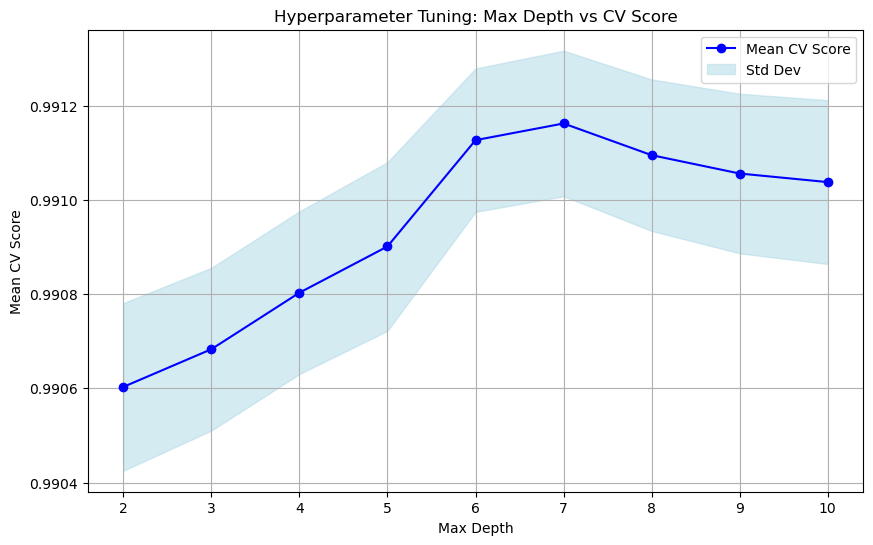

Fitting the final model with optimal max_depth = 7...

Model fitting complete.

Generating classification report and confusion matrix...


### Classification Report of LightGBM (Best Max Depth)

,Classifier,Model Definition,Class 0 - Precision,Class 0 - Recall,Class 0 - F1-Score,Class 1 - Precision,Class 1 - Recall,Class 1 - F1-Score,Average - Precision,Average - Recall,Average - F1-Score,Accuracy,Confusion Matrix
0,LightGBM,"LGBMClassifier(learning_rate=0.05, max_depth=7...",0.998983,0.983325,0.991092,0.983582,0.998999,0.991231,0.991283,0.991162,0.991162,0.991162,"[[3484475, 59089], [3546, 3540018]]"


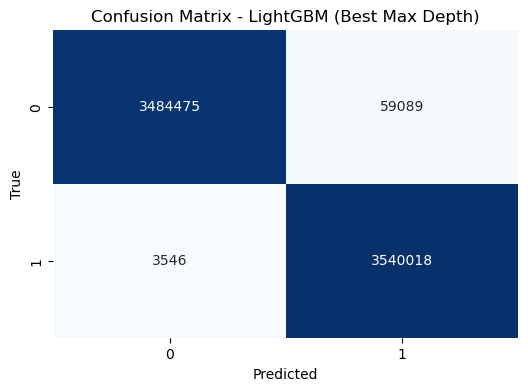

Model trained with optimal max_depth: 7, achieving best CV score of: 99.12%


In [ ]:
def light_gbm(lgbm_learning_rate, num_leaves, df_norm):
    # Define the features and target
    X = df_norm.drop(columns=['Burn_Label'])
    Y = df_norm['Burn_Label']
    
    max_depth_range = range(2, 11)  # Range of max_depth to test (2 to 10)
    cv_scores = []  # Store mean cross-validation scores
    cv_std_devs = []  # Store standard deviation of cross-validation scores
    
    print("Performing hyperparameter tuning for max_depth in range 2-10...")
    
    for max_depth in max_depth_range:
        params = {
            'verbose': -1,
            'learning_rate': lgbm_learning_rate,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': max_depth,
            'num_leaves': num_leaves
        }
        
        # Initialize the LightGBM model
        lgbm_model = LGBMClassifier(**params)
        
        # 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        lgbm_scores = cross_val_score(lgbm_model, X, Y, cv=kf)
        
        # Store the mean and std of cross-validation scores
        cv_scores.append(lgbm_scores.mean())
        cv_std_devs.append(lgbm_scores.std())
        
        print(f"Max Depth: {max_depth}, CV Score: {round(lgbm_scores.mean() * 100, 2)}%, Std Dev: {round(lgbm_scores.std() * 100, 2)}%")
    
    # Find the optimal max_depth based on highest mean CV score
    optimal_index = np.argmax(cv_scores)
    optimal_max_depth = max_depth_range[optimal_index]
    best_cv_score = cv_scores[optimal_index]
    
    print(f"\nOptimal Max Depth: {optimal_max_depth} with CV Score: {round(best_cv_score * 100, 2)}%")
    
    # Plot the cross-validation results
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_range, cv_scores, marker='o', linestyle='-', color='b', label='Mean CV Score')
    plt.fill_between(max_depth_range, 
                     np.array(cv_scores) - np.array(cv_std_devs), 
                     np.array(cv_scores) + np.array(cv_std_devs), 
                     color='lightblue', alpha=0.5, label='Std Dev')
    plt.title('Hyperparameter Tuning: Max Depth vs CV Score')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean CV Score')
    plt.xticks(max_depth_range)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Fit the model with the optimal max_depth
    print(f"Fitting the final model with optimal max_depth = {optimal_max_depth}...")
    final_params = {
        'verbose': -1,
        'learning_rate': lgbm_learning_rate,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': optimal_max_depth,
        'num_leaves': num_leaves
    }
    
    lgbm_model = LGBMClassifier(**final_params)
    lgbm_model.fit(X, Y)
    
    print("\nModel fitting complete.")
    
    # Generate classification report and confusion matrix
    print("\nGenerating classification report and confusion matrix...")
    y_pred = cross_val_predict(lgbm_model, X, Y, cv=kf)
    report = classification_report(Y, y_pred, output_dict=True)
    cm = confusion_matrix(Y, y_pred)
    
    # Create a summary of the results
    lgbm_result = [{
        'Classifier': 'LightGBM',
        'Model Definition': lgbm_model,
        'Class 0 - Precision': report['0']['precision'],
        'Class 0 - Recall': report['0']['recall'],
        'Class 0 - F1-Score': report['0']['f1-score'],
        'Class 1 - Precision': report['1']['precision'],
        'Class 1 - Recall': report['1']['recall'],
        'Class 1 - F1-Score': report['1']['f1-score'],
        'Average - Precision': report['macro avg']['precision'],
        'Average - Recall': report['macro avg']['recall'],
        'Average - F1-Score': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy'],
        'Confusion Matrix': cm
    }]
    
    lgbm_result_df = pd.DataFrame(lgbm_result)
    
    display(Markdown("### Classification Report of LightGBM (Best Max Depth)"))
    display(lgbm_result_df)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - LightGBM (Best Max Depth)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return lgbm_model, optimal_max_depth, best_cv_score

# Call the function with the parameters and your DataFrame
lgbm_model, optimal_max_depth, best_cv_score = light_gbm(0.05, 31, df_norm)

print(f"Model trained with optimal max_depth: {optimal_max_depth}, achieving best CV score of: {round(best_cv_score * 100, 2)}%")

## Export LightGBM Model as pickle

In [ ]:
savepath = r'Export Model'
lgbm_filename_model = os.path.join(savepath, 'Model_LGBM_DownSP.sav')
pickle.dump(lgbm_model, open(lgbm_filename_model, 'wb'))

## Training with Random Forest Classified

In [ ]:
#def random_forest(df, random_forest_estimator_num=100, criterion="gini"):
    #"""Performs hyperparameter tuning for Random Forest to find optimal max_depth
    #and plots the results."""
    #display(Markdown("### Hyperparameter Tuning for Random Forest"))
    #print()  # Add Blank Line

    # Define the features and target
    #X = df.drop(columns=['Burn_Label'])  # Features: all columns except Burn_Label
    #Y = df['Burn_Label']                 # Target: Burn_Label column

    # Set up cross-validation
    #kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation
    
    #max_depths = list(range(2, 21))  # Range of max_depth to test
    #mean_cv_scores = []

    # Perform hyperparameter tuning
    #for max_depth in max_depths:
        #rdf_model = RandomForestClassifier(n_estimators=random_forest_estimator_num,
                                           #max_depth=max_depth,
                                           #criterion=criterion,
                                           #random_state=42)
        #scores_cv = cross_val_score(rdf_model, X, Y, cv=kf)
        #mean_cv_scores.append(scores_cv.mean())

    # Plotting the mean cross-validation accuracy vs. max_depth
    #plt.figure(figsize=(10, 6))
    #plt.plot(max_depths, mean_cv_scores, marker='o', linestyle='-', color='blue')
    #plt.xlabel('Max Depth')
    #plt.ylabel('Mean CV Accuracy')
    #plt.title('Random Forest - Max Depth vs. Mean CV Accuracy')
    #plt.xticks(max_depths)
    #plt.grid(True)
    #plt.show()

    # Find the best max_depth
    #best_max_depth = max_depths[np.argmax(mean_cv_scores)]
    #print(f"Best Max Depth: {best_max_depth} with Mean CV Accuracy: {round(max(mean_cv_scores) * 100, 2)}%")

    # Train and evaluate Random Forest with the best max_depth
    #rdf_model_best = RandomForestClassifier(n_estimators=random_forest_estimator_num,
                                            #max_depth=best_max_depth,
                                            #criterion=criterion,
                                            #random_state=42)
    #rdf_model_best.fit(X, Y)
    #scores_cv = cross_val_score(rdf_model_best, X, Y, cv=kf)
    #mean_cv = scores_cv.mean()
    #std_cv = scores_cv.std()

    # Display Cross-validation results
    #print(f"Random Forest (Best Max Depth = {best_max_depth}) Cross-validation scores: {round(mean_cv * 100, 2)}%")
    #print(f"Random Forest (Best Max Depth = {best_max_depth}) Standard deviation: {round(std_cv * 100, 2)}%")
    
    # Generate classification report
    #y_pred = cross_val_predict(rdf_model_best, X, Y, cv=kf)
    #report = classification_report(Y, y_pred, output_dict=True)
    #cm = confusion_matrix(Y, y_pred)
    
    #rdf_result = [{
        #'Classifier': 'Random Forest',
        #'Model Definition': rdf_model_best,
        #'Class 0 - Precision': report['0']['precision'],
        #'Class 0 - Recall': report['0']['recall'],
        #'Class 0 - F1-Score': report['0']['f1-score'],
        #'Class 1 - Precision': report['1']['precision'],
        #'Class 1 - Recall': report['1']['recall'],
        #'Class 1 - F1-Score': report['1']['f1-score'],
        #'Average - Precision': report['macro avg']['precision'],
        #'Average - Recall': report['macro avg']['recall'],
        #'Average - F1-Score': report['macro avg']['f1-score'],
        #'Accuracy': report['accuracy'],
        #'Confusion Matrix': cm
    #}]
    
    #rdf_result_df = pd.DataFrame(rdf_result)
    
    #display(Markdown("### Classification Report of Random Forest (Best Max Depth)"))
    #display(rdf_result_df)
    
    # Plot Confusion Matrix
    #plt.figure(figsize=(6, 4))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    #plt.title('Confusion Matrix - Random Forest (Best Max Depth)')
    #plt.xlabel('Predicted')
    #plt.ylabel('True')
    #plt.show()

    #print()  # Add Blank Line
    #display(Markdown("<span style='color: green; font-weight: bold;'>Random Forest Model Run Complete</span>"))
    #print()  # Add Blank Line

    #return rdf_model_best, mean_cv, std_cv

# Call the tune_random_forest function with the desired parameters and your DataFrame
#rdf_model_best, mean_cv_best, std_cv_best = random_forest(df_norm)

### Export Random Forest as pickle

In [ ]:
#savepath = r'Export Model'
#rdf_filename_model = os.path.join(savepath, 'Model_RDF.sav')
#pickle.dump(rdf_model_best, open(rdf_filename_model, 'wb'))

## Fully Connected Neural Netwok (FCNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, Markdown

# Ensure correct GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Set TensorFlow to use GPU 1 (NVIDIA T1000)
        tf.config.set_visible_devices(gpus[1], 'GPU')
        print(f"Using GPU: {gpus[1].name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Using CPU.")

# Assume df_norm is the provided DataFrame with 414,551 rows and 16 columns
# df_norm contains the features and 'Burn_Label' as the target
X = df_norm.drop(columns=['Burn_Label']).values  # Features: all columns except Burn_Label
Y = df_norm['Burn_Label'].values                 # Target: Burn_Label column

def fcnn_classified(X, Y):
    # FCNN model creation
    def create_fcnn_model(input_dim):
        model = Sequential([
            Dense(128, activation='relu', input_dim=input_dim),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    display(Markdown("### FCNN Model Initializing"))
    print()  # Add Blank Line

    input_dim = X.shape[1]  # Number of features
    fcnn_model = create_fcnn_model(input_dim)

    # Use GPU for training if available
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fcnn_scores = []
        train_acc_history = []
        val_acc_history = []
        train_loss_history = []
        val_loss_history = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Train FCNN with history tracking
            history = fcnn_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32, verbose=0)

            # Collect accuracy and loss data
            train_acc_history.extend(history.history['accuracy'])
            val_acc_history.extend(history.history['val_accuracy'])
            train_loss_history.extend(history.history['loss'])
            val_loss_history.extend(history.history['val_loss'])

            # Evaluate the model on the test set
            score = fcnn_model.evaluate(X_test, Y_test, verbose=0)
            fcnn_scores.append(score[1])  # Test accuracy

        mean_cv = np.mean(fcnn_scores)
        std_cv = np.std(fcnn_scores)

        print(f"FCNN Cross-validation accuracy: {round(mean_cv * 100, 2)}%")
        print(f"FCNN Standard deviation: {round(std_cv * 100, 2)}%")
        print('FCNN | Cross-validation results:')
        
        for indx, score in enumerate(fcnn_scores, start=1):
            if score == np.amax(fcnn_scores):
                print(f'\033[91m Accuracy in fold {indx} : {round(score * 100, 2)}%\033[90m')
            else:
                print(f'Accuracy in fold {indx} : {round(score * 100, 2)}%')

        # Plot Training and Validation Accuracy
        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(train_acc_history, label='Training Accuracy')
        plt.plot(val_acc_history, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(train_loss_history, label='Training Loss')
        plt.plot(val_loss_history, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

        # Predict using cross-validation
        y_pred = (fcnn_model.predict(X).round()).astype(int).flatten()

        # Classification report and confusion matrix
        report = classification_report(Y, y_pred, output_dict=True)
        cm = confusion_matrix(Y, y_pred)
        tn, fp, fn, tp = cm.ravel()  # Get confusion matrix values

        fcnn_result = []
        fcnn_result.append({
            'Classifier': 'FCNN',
            'Model Definition': fcnn_model,
            'Class 0 - Precision': report['0']['precision'],
            'Class 0 - Recall': report['0']['recall'],
            'Class 0 - F1-Score': report['0']['f1-score'],
            'Class 1 - Precision': report['1']['precision'],
            'Class 1 - Recall': report['1']['recall'],
            'Class 1 - F1-Score': report['1']['f1-score'],
            'Average - Precision': report['macro avg']['precision'],
            'Average - Recall': report['macro avg']['recall'],
            'Average - F1-Score': report['macro avg']['f1-score'],
            'Accuracy': report['accuracy'],
            'Confusion Matrix': cm,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp
        })

        fcnn_result_df = pd.DataFrame(fcnn_result)

        display(Markdown("### Classification Report of FCNN: "))
        display(fcnn_result_df)
        print()  # Add Blank Line

        # Plot Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix - FCNN')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        print()  # Add Blank Line
        display(Markdown("<span style='color: green; font-weight: bold;'>FCNN Model Run Complete</span>"))
        print()  # Add Blank Line

        # Fit the model on the entire dataset
        print("Fitting the model on the entire dataset.")
        fcnn_model.fit(X, Y, epochs=10, batch_size=32, verbose=0)

    return fcnn_model, mean_cv, std_cv

# Call the FCNN function with your DataFrame
fcnn_model, mean_cv, std_cv = fcnn_classified(X, Y)

GPU is available!


### FCNN Model Initializing

KeyboardInterrupt: 